In [1]:
import czifile
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from skimage import filters, measure, segmentation, feature, img_as_ubyte, morphology
from scipy import ndimage as ndi
import pandas as pd


**The intial preprocessing and locating centers is derived from Ciera's notebook on explore_nucleiu_segment.**

In [2]:
## Read in example file
array = czifile.imread("/Users/samanthatang/Desktop/stack_data/dmel_st14__i_63x-02.czi")

## Use squeeze to get rid of channels my data doesnt have.
array = array.squeeze()

array.shape ## Check

(6, 2, 21, 928, 1389)

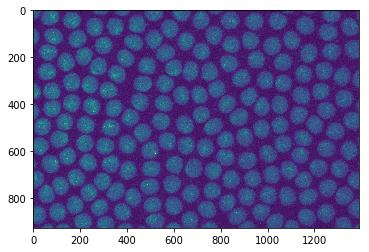

In [4]:
zstack = array[1, 1, :, ...]
zstack.shape

zstack_MAX= np.max(zstack, axis=0)
plt.imshow(zstack_MAX)
plt.show()

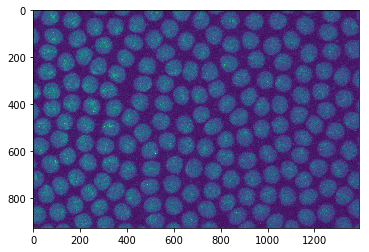

In [6]:
# Convert to 8bit
zstack_MAX_8bit = img_as_ubyte(zstack_MAX)
plt.figure()
plt.imshow(zstack_MAX_8bit);

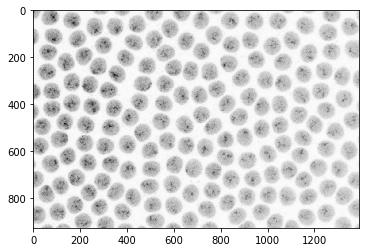

In [10]:
#### PART 1: Find centers with a conservative threshold

### First perform the conservative threshold on every point in the Z axis with the Otsu threshold
zstack_MAX_8bit_GausFilt = ndi.filters.gaussian_filter(zstack_MAX_8bit, 1) # blur image and remove noise

plt.imshow(zstack_MAX_8bit_GausFilt, cmap = "Greys");

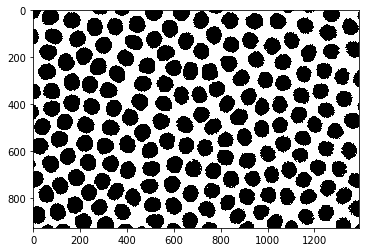

In [15]:
otsuthresh = filters.threshold_otsu(zstack_MAX_8bit_GausFilt) # grey scale (find a threshold number) = 38
zstack_MAX_8bit_GausFilt_localtheshold = zstack_MAX_8bit_GausFilt > otsuthresh

plt.imshow(zstack_MAX_8bit_GausFilt_localtheshold, cmap="Greys");

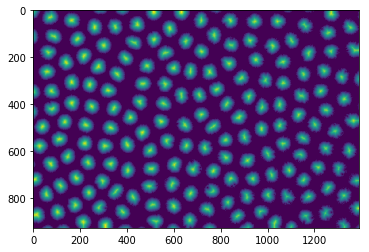

In [22]:
#### Then Call centers 
### Distance transform
distancetransform_combined_final = ndi.distance_transform_edt(zstack_MAX_8bit_GausFilt_localtheshold)
plt.imshow(distancetransform_combined_final);

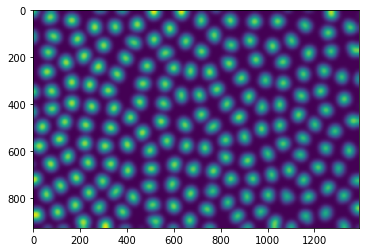

In [24]:
#### smoothen the distance transform
distancetransform_combined_final_gaus = ndi.filters.gaussian_filter(distancetransform_combined_final, 10)

plt.imshow(distancetransform_combined_final_gaus); #ciera had this as color reds

In [48]:
#### Retrieve the local maxima from the distance transform
## Gives a true false for every pixel if it is the max local peak?
Local_max = feature.peak_local_max(distancetransform_combined_final_gaus, indices = False, min_distance = 40)
Local_max_bigger = ndi.filters.maximum_filter(Local_max, size=20)

#makes a mask so that I can visualize on top of the original image
Local_max_mask = np.ma.array(Local_max_bigger, mask=Local_max_bigger==0)

#Add that mask back into the watershed image
CenterPointArrays = Local_max_bigger

In [49]:
Local_max #same as local max BIGGER, just that the dots are too small to see here so need to adjust size

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [50]:
Local_max_bigger

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [51]:
# Local_max_mask #mask for visualizing

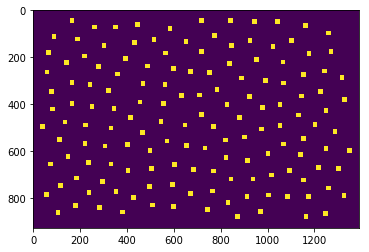

In [52]:
plt.imshow(Local_max_bigger); #located the centers

In [53]:
#### PART 2: Now make a mask with a permissive threshold that goes all the way to the edges of the nuclei.
image_GausFilt = ndi.filters.gaussian_filter(zstack_MAX_8bit, 20)
localthresh = filters.threshold_local(image_GausFilt, 41)
image_GausFilt_localtheshold = image_GausFilt > localthresh
image_GausFilt_localtheshold_dilate = morphology.binary_dilation(image_GausFilt_localtheshold)
EdgeMask = image_GausFilt_localtheshold_dilate

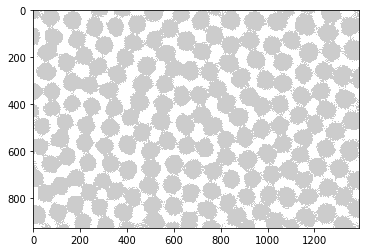

In [59]:
plt.imshow(EdgeMask, alpha=0.2, cmap='Greys'); #there's also a separated version that might be interesting to look at

process... This is probably just another thresholding mechanism to separate foreground/background to isolate nucleus, not sure if this can be used to gather coordinates or area.

In [79]:
image_GausFilt #numbers

array([[55, 55, 55, ..., 25, 25, 25],
       [55, 55, 55, ..., 25, 25, 25],
       [55, 55, 55, ..., 25, 25, 25],
       ...,
       [35, 35, 35, ..., 29, 29, 29],
       [35, 35, 35, ..., 29, 29, 29],
       [35, 35, 35, ..., 29, 29, 29]], dtype=uint8)

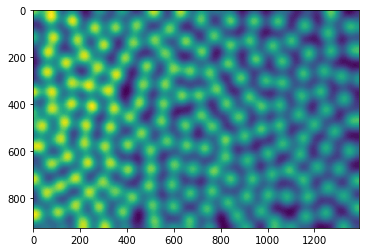

In [66]:
plt.imshow(image_GausFilt); #numbers

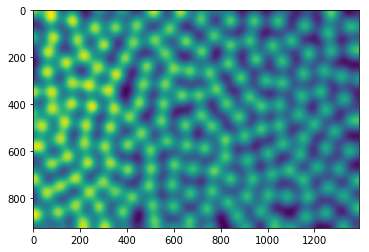

In [67]:
plt.imshow(localthresh); #numbers array

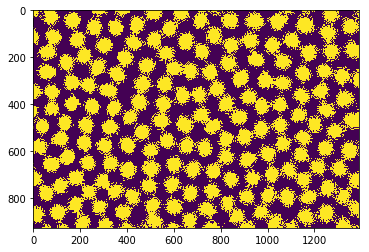

In [68]:
plt.imshow(image_GausFilt_localtheshold); #true/false array

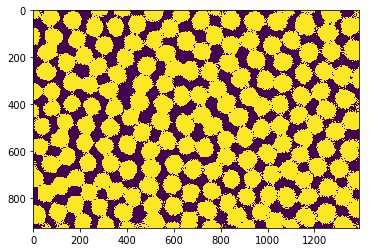

In [69]:
plt.imshow(image_GausFilt_localtheshold_dilate); #true/false array

In [82]:
localthresh

array([[53.36763691, 53.34542744, 53.30120624, ..., 24.73443   ,
        24.76377219, 24.77851203],
       [53.33302244, 53.3108722 , 53.26676838, ..., 24.74297312,
        24.77221821, 24.78690872],
       [53.26389554, 53.24186284, 53.19799204, ..., 24.76018743,
        24.78924095, 24.80383415],
       ...,
       [35.67053265, 35.6695561 , 35.66760288, ..., 28.92579496,
        28.91091026, 28.90355597],
       [35.59811555, 35.59716377, 35.59526153, ..., 28.94466146,
        28.92982015, 28.92248979],
       [35.56196059, 35.56102035, 35.55914194, ..., 28.95410647,
        28.93928709, 28.93196884]])

In [75]:
CenterPointArrays #true false array

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

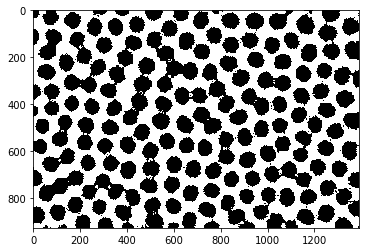

In [236]:
## EdgeMask Gaussian septerated. 
## Why not just do this instead of watershed?
EdgeMask_gauss = ndi.filters.gaussian_filter(EdgeMask, .5)
plt.imshow(EdgeMask_gauss, "Greys");

In [237]:
EdgeMask_gauss #could prob turn into 1's and 0's and gather info from there

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])

In [238]:
binary = EdgeMask_gauss * 1 #turned into 1's and 0's 
binary

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])

In [239]:
from skimage.feature import corner_harris, corner_foerstner, corner_peaks, corner_subpix

In [240]:
# w, q = corner_foerstner(binary)
# accuracy_thresh = 0.5
# roundness_thresh = 0.3
# foerstner = (q > roundness_thresh) * (w > accuracy_thresh) * w
# corner_peaks(foerstner, min_distance=1) 

#look into as another method to use? 

In [258]:
coords = corner_peaks(corner_harris(binary), min_distance=1)
coords

array([[   1,    1],
       [   1,   25],
       [   1,   54],
       ...,
       [ 926, 1130],
       [ 926, 1288],
       [ 926, 1364]])

In [259]:
len(coords)

5826

In [260]:
coords_subpix = corner_subpix(binary, coords, window_size=13)
coords_subpix

array([[-4.84615385e-01, -4.84615385e-01],
       [-4.06596794e-01,  2.48847102e+01],
       [-4.82281629e-01,  5.35152316e+01],
       ...,
       [            nan,             nan],
       [ 9.27329843e+02,  1.28771622e+03],
       [ 9.27190461e+02,  1.36499031e+03]])

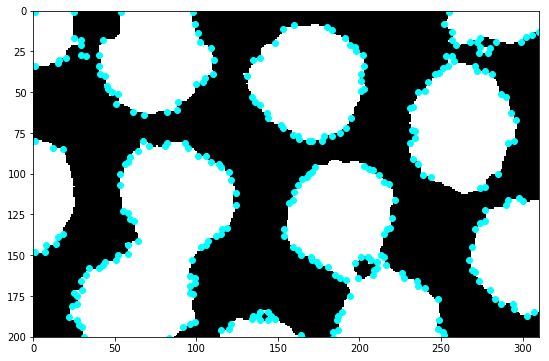

In [261]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(binary, cmap=plt.cm.gray)
ax.plot(coords[:, 1], coords[:, 0], color='cyan', marker='o',linestyle='None', markersize=6)
# ax.plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=15)
ax.axis((0, 310, 200, 0)) #subset/closer look cuz too much if full size (top upper left corner)
plt.show()

In [262]:
coords[:, 1], coords[:, 0]

(array([   1,   25,   54, ..., 1130, 1288, 1364]),
 array([  1,   1,   1, ..., 926, 926, 926]))

In [263]:
coords #how to group them? perform a cluster analysis on these coordinate points? 

array([[   1,    1],
       [   1,   25],
       [   1,   54],
       ...,
       [ 926, 1130],
       [ 926, 1288],
       [ 926, 1364]])

In [247]:
#clustering
from sklearn.cluster import DBSCAN

In [250]:
cluster_ft = DBSCAN(eps=40, min_samples=30)
labels = cluster_ft.fit_predict(coords)
np.unique(labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47])

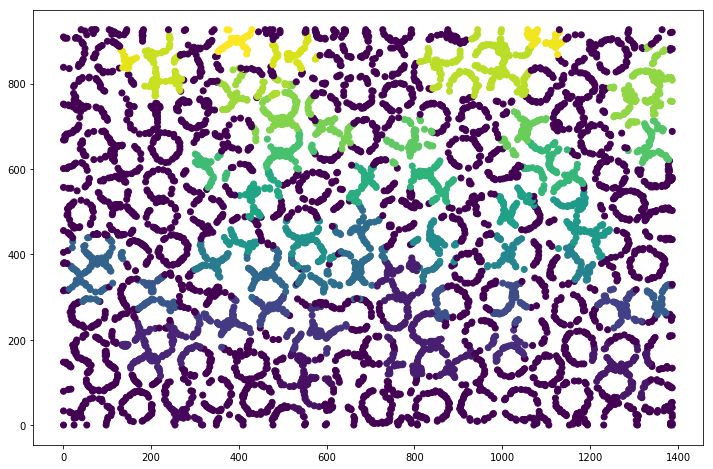

In [251]:
plt.figure(figsize=(12, 8))
plt.scatter(coords[:, 1], coords[:, 0], c=cluster_ft.labels_);